# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

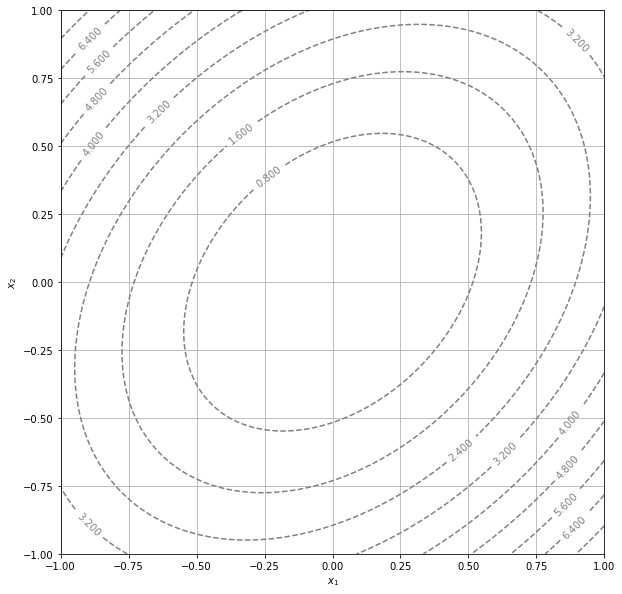

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

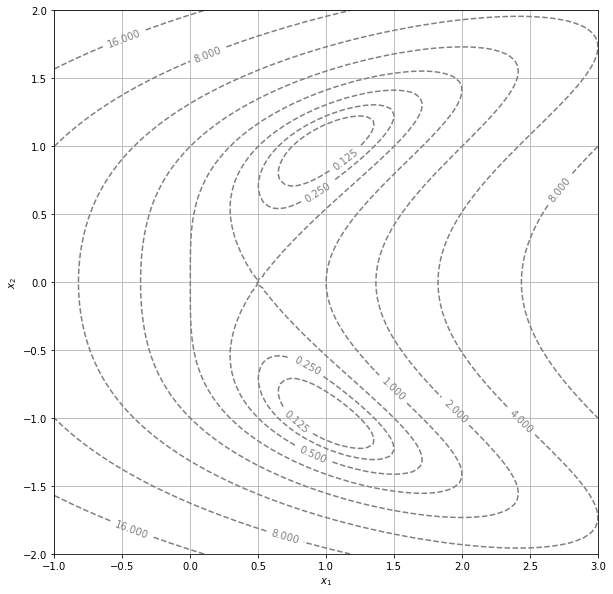

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

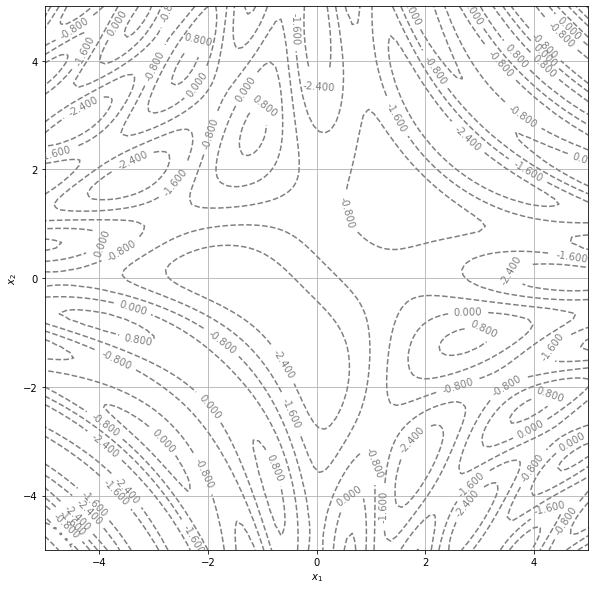

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?


$\underline{\textbf{Réponse}} : $

On note $N_{c}$ la courbe de niveau de f correspondant à la valeur c, on remarque alors que $N_{c} = f^{<-1>}(\{c\})$. $\{c\}$ étant un fermé et f étant continue, on peut conclure que $N_{c}$ est aussi un fermé comme image réciproque d'un fermé par une application continue.


De plus, comme $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, il existe un $r>0$ tel que pour tout $x \in \mathbb{R^2}$ avec $\|x\| > r$, $f(x) \geq c + 1$, il est donc immédiat que $N_{c}$ est borné.


Nous sommes de plus en dimension finie, nous pouvons donc conclure que $\mathbf{N_{c} }  \textbf{est un compact}$

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

$\underline{\textbf{Réponse}} : $

On remarque facilement que $p(x_1,x_2) = \begin{vmatrix}
x_{1} - x_{10} & \frac{\partial f}{\partial x}(x_{0})\\ 
x_{2} - x_{20} & \frac{\partial f}{\partial y}(x_{0})
\end{vmatrix}
\frac{1}{\left \| \overrightarrow{grad}(f)(x_0) \right \|}$

Ce qui correspond à $\textbf{l'aire du parallélogramme}$ formé par les deux vecteurs $x-x_0$ et $\overrightarrow{grad}(f)(x_0)$, normalisée par la norme de ce dernier.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

$\underline{\textbf{Réponse}} : $


On va utiliser le théorème des fonctions implicites.

On introduit la fonction $F : \mathbb{R}^{2} \to \mathbb{R}^{2}$ définie par : $F((x_1,x_2),t) = \begin{pmatrix}
f(x_1,x_2) - c\\ 
p(x_1,x_2) - t
\end{pmatrix}$

$\bullet$ La fonction $F$ est de classe $C^1$ car chaque coordonnée l'est. (le caractère $C^1$ de $p$ est immédiat)


$\bullet$ On peut calculer :
$$
\partial_xF((x_1,x_2),t) = \begin{pmatrix}
\partial_1f(x_1,x_2) & \partial_2f(x_1,x_2)\\ 
\frac{\partial_2f(x_0)}{\left \| \nabla f(x_0) \right \|} & \frac{\partial_1f(x_0)}{\left \| \nabla f(x_0) \right \|}
\end{pmatrix}
$$
Et on vérifie que le déterminant de cette matrice pour $(x_1,x_2) = x_0$ vaut $-\left \| \nabla f(x_0) \right \|$, qui est non nul par hypothèse, donc non nul sur un voisinage de $0$

$\bullet$ De plus, $F(x_0,0) = \begin{pmatrix}
0\\ 
0
\end{pmatrix}$

Donc $\textbf{d'après le théorème des fonctions implicites}$, il existe un voisinage $\left]-\varepsilon,\varepsilon \right[$ de $0$ (avec $\varepsilon > 0$) et un voisinage $V$ de $x_0$ tel que :
$$
\forall x = \begin{pmatrix}
x_1\\ 
x_2
\end{pmatrix} \in V ,  F(x,t) = 0 \Leftrightarrow (x_1,x_2) = \gamma (t) 
$$

Avec $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ continûment différentiable, et on obtient $\mathbf{t = p(x_1,x_2)}$ en annulant la deuxième coordonnée de $F$ !

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

$\underline{\textbf{Réponse}} : $

Soit $t \in \left]-\varepsilon, \varepsilon \right[$.

Le théorème des fonctions implicites donne de plus : ${\gamma}'(t) = -(\partial_xF(x,t))^{-1}\circ \partial_tF(x,t)$.

Comme $\partial_tF(x,t) = \begin{pmatrix}
0\\ 
-1
\end{pmatrix}$
, Le calcul donne :
$$
{\gamma}'(t) = -\left \| \nabla f(x_0) \right \|\begin{pmatrix}
\partial_2f(x_1,x_2)\\ 
-\partial_1f(x_1,x_2)
\end{pmatrix}
$$
(avec $(x_1,x_2) = \gamma (t)$)


Qui est non nul sur $\left]-\varepsilon, \varepsilon \right[$ d'après ce qui précède. Donc $\mathbf{{\gamma (t)}' \neq 0}$.

Et on vérifie également que $< {\gamma}'(t)\mid \nabla f(\gamma (t))> = 0$ pour $< \cdot \mid \cdot >$ le produit scalaire canonique sur $\mathbb{R}^2$. Donc $\mathbf{{\gamma}'(t)\perp \nabla f(\gamma (t))}$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

$\underline{\textbf{Réponse}} : $

La valeur de $10^{-8}$ pour $\varepsilon$ permet une précision satisfaisante tout en garantissant une convergence de la méthode de Newton en un nombre raisonnable de tours. !

In [14]:
N = 100
eps = 1e-8

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    """Résout une équation du type F(x) = 0 avec F : R2 -> R2"""
    J_f = J(F)
    x,y = x0,y0
    for i in range(N):
        x,y = np.array([x0,y0]) - np.dot(np.linalg.inv(J_f(x0,y0)),F(x0,y0))
        dist = np.sqrt((x - x0)**2 + (y - y0)**2)
        if  dist <= eps:
            return np.array([x, y])
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

Testons la fonction Newton sur la fonction $f_1$ :

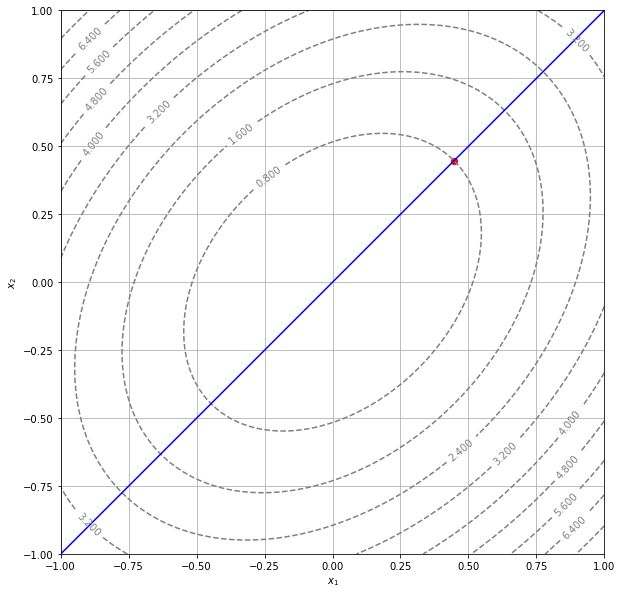

In [16]:
"""Implémentons d'abord les fonctions nécessaires..."""
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2

def F1(x1, x2):    #La fonction de R2 dans R2 (avec contrainte supplémentaire !)
    return np.array([f1(x1,x2) - 0.8, x1 - x2])

display_contour(   #on trace tout d'abord les lignes de niveau
    f1, 
    x = np.linspace(-1.0, 1.0, 100), 
    y = np.linspace(-1.0, 1.0, 100), 
    levels=10
)

nx, ny = Newton(F1,0.8,0.8)
plt.plot(np.linspace(-1.0, 1.0, 100), np.linspace(-1.0, 1.0, 100),'b')
plt.scatter(nx, ny, c = 'r', s = 40)

On constate alors bien que le point a été trouvé ! Passons à la suite pour tracer complètement les lignes de niveau...

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

$\underline{\textbf{Réponse}} : $

Pour générer les points, au lieu d'une contrainte sur la deuxième coordonée de $F$ du type $x_1 - x_2 = 0$, on va faire une contrainte du type $\left \| x-x_0 \right \| - \delta  = 0$ afin de trouver des points chacun espacés de la distance $\delta$.

Il faut noter que l'on utilise quand même la condition $x_1 - x_2 = 0$ pour amorcer le premier point de la courbe de niveau.

In [17]:
def level_curve(f,x0,y0,c,delta = 0.1, N2 = 100, eps=eps):
    """ Trace la courbe de niveau de f par traçage de cercles successifs"""
    grad_f = grad(f)
    X,Y = [x0],[y0]
    x, y = x0, y0
    def F(x, y, x1, y1):
        return np.array([f(x,y) - c, np.sqrt((x-x1)**2 + (y-y1)**2) - delta])
    for i in range(N2):
        gf = grad_f(x, y)
        u = np.array([gf[1], -gf[0]])
        u = u/np.linalg.norm(u)
        x,y = x + delta*u[0], y + delta*u[1]   #on s'avance dans la direction "à droite" du gradient de f pour trouver le nouveau point de départ de la fonction Newton
        x,y = Newton(lambda a,b : F(a,b,X[-1],Y[-1]),x,y)
        X.append(x)
        Y.append(y)
    return np.array([X,Y])

Testons maintenant la fonction level_curve sur plusieurs exemples ! D'abord sur la fonction $f_1$ : (on trace la courbe de niveau correspondant à la valeur $0,8$)

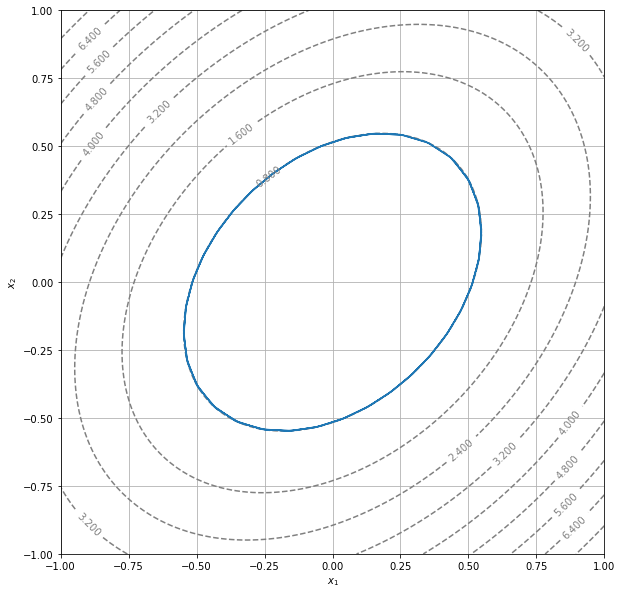

In [18]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2

def F1(x1, x2):    #La fonction de R2 dans R2 qui sert à amorcer la level_curve
    return np.array([f1(x1,x2) - 0.8, x1 - x2]) 

display_contour(   #on trace tout d'abord les lignes de niveau
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)

nx,ny = Newton(F1, 0.5, 0.5)   #les points pour amorcer la fonction level_curve

XY = level_curve(f1, nx, ny, 0.8)
plt.plot(XY[0], XY[1])

Essayons maintenant level_curve sur la fonction $f_2$ : (on trace la courbe de niveau correspondant à la valeur $0,250$)

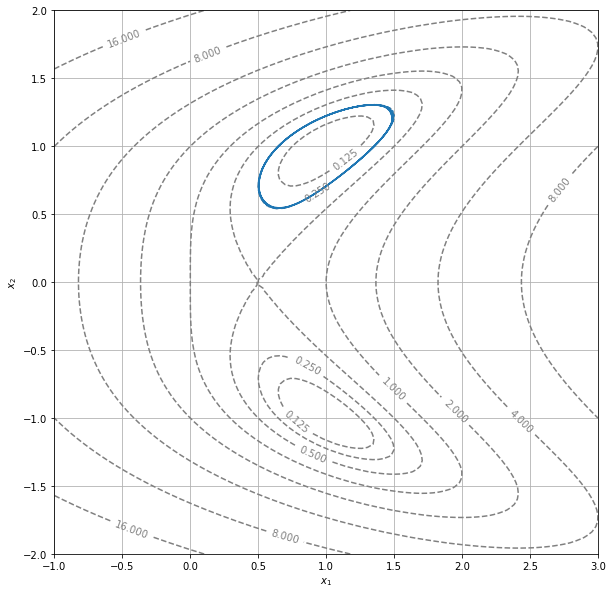

In [19]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

def F2(x1, x2):    #La fonction de R2 dans R2 qui sert à amorcer la level_curve
    return np.array([f2(x1,x2) - 0.250, x1 - x2]) 

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

nx, ny = Newton(F2, 0.8, 0.8)   #les points pour amorcer la fonction level_curve

XY = level_curve(f2, nx, ny, 0.250)
plt.plot(XY[0], XY[1])

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

$\underline{\textbf{Réponse}} : $

Pour empêcher l'algorithme de faire plusieurs fois le tour d'une boucle, on va utiliser une méthode qui consiste à vérifier si un point se trouve à une distance de $x_0$ (point d'amorce de level_curve) inférieure à $\frac{\delta}{1.3}$. Si un tel point est trouvé, cela veut dire que l'on est déjà passé par là et qu'il est inutile de continuer.

Nous pouvons également considérer que les courbes "auto-intersectantes" sont rares dans les cas "simples", on peut donc se contenter de vérifier seulement la distance avec $x_0$, ce qui fera l'affaire pour les courbes $f_1$ et $f_3$ comme nous le verrons.

Un simple ajout d'une condition dans la boucle permet de le faire :

In [20]:
def level_curveameliore(f, x0, y0, c, delta = 0.1, N2 = 1000, eps = eps):
    grad_f = grad(f)
    X, Y = [x0], [y0]
    x, y = x0, y0
    def F(x, y, x1, y1):
        return np.array([f(x, y) - c, np.sqrt((x-x1)**2 + (y-y1)**2) - delta])
    for i in range(N2):
        gf = grad_f(x, y)
        u = np.array([gf[1], -gf[0]])
        u = u/np.linalg.norm(u)
        x,y = x + delta*u[0], y + delta*u[1]
        x,y = Newton(lambda a, b : F(a,b,X[-1], Y[-1]), x, y)
        dist = np.sqrt((x-x0)**2 + (y-y0)**2)
        if dist < delta/1.3:
            print(f"i = {i} !")
            return np.array([X, Y])
        X.append(x)
        Y.append(y)
    return np.array([X, Y])

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.


Pour la fonction $f_1$, essayons, avec un delta égal à $0.1$, de générer $10000$ points selon la méthode utilisée avec level_curve. Normalement, cette fonction est censée prendre beaucoup de temps à s'éxecuter, mais ici, elle s'arrête dès qu'un tour est fait ! On peut même renvoyer la valeur de $i$ pour vérifier que l'algorithme n'a effectué qu'une dizaine de tours...

i = 33 !


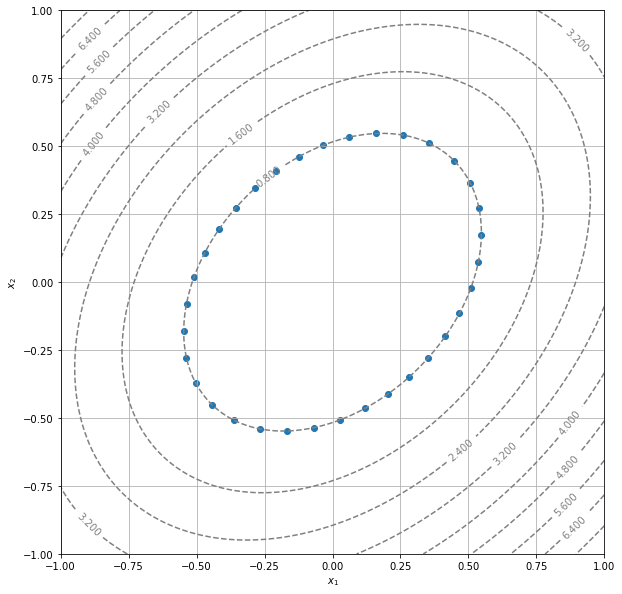

In [21]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2

def F1(x1, x2):    #La fonction de R2 dans R2 qui sert à amorcer la level_curve
    return np.array([f1(x1,x2) - 0.8, x1 - x2]) 

display_contour(   #on trace tout d'abord les lignes de niveau
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)

nx, ny = Newton(F1, 0.5, 0.5)   #les points pour amorcer la fonction level_curve

XY = level_curveameliore(f1, nx, ny, 0.8, delta = 0.1, N2 = 10000)
plt.scatter(XY[0], XY[1])

Pour ce qui est de la fonction $f_3$, on va tester la même chose :

i = 139 !


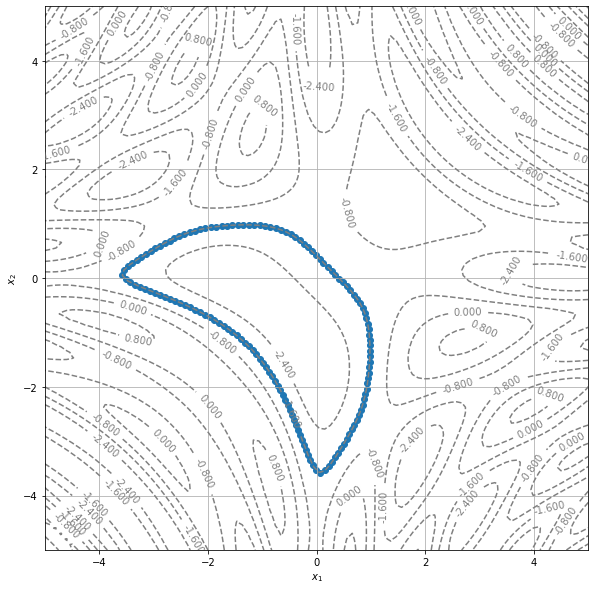

In [22]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

def F3(x1,x2):    #La fonction de R2 dans R2 qui sert à amorcer la level_curve
    return np.array([f3(x1,x2) + 1.6, x1 - x2]) 

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

nx, ny = Newton(F3, 0.5, 0.5)   #les points pour amorcer la fonction level_curve

XY = level_curveameliore(f3, nx, ny, -1.6, delta = 0.1, N2 = 10000)
plt.scatter(XY[0], XY[1])

Comme prévu, ici l'algorithme ne fait qu'une centaine de tours au lieu des 10000 prévus ! Et la courbe de niveau est bien complète.

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

$\underline{\textbf{Réponse}} : $

Les conditions en 0 et 1 sur $\gamma $ vont nous permettre de déterminer les cas où l'Interpolation est possible, ainsi que les valeurs des six paramètres dans ce cas. 
Nous pouvons en premier lieu résoudre complètement le problème mathématique : 

La condition $\gamma(0) = P_1$ nous donne directement : $ a = P_1^1 \ ;  d= P_1^2 $

De même, la condition $\gamma(1) = P_2$ nous donne :
$$
\left\{\begin{matrix}
 a+b+c&=&P_2^1 \\ 
 d+e+f& = &P_2^2
\end{matrix}\right.
$$

Ensuite, nous voulons $\gamma'(0)$ colinéaire à $u_1$ et de même sens, et $\gamma'(1)$ colinéaire à $u_2$ et de même sens.

On veut donc $\alpha$ et $\beta$ strictements positifs tels que $\gamma'(0) = {\alpha}u_1$ et $\gamma'(1) = {\beta}u_2$, soit : 
$$
\left\{\begin{matrix}
 b&=&{\alpha}u_1^1 \\ 
 e&=&{\alpha}u_1^2\\
 b+2c&=&{\beta}u_2^1\\
e+2f&=&{\beta}u_2^2
\end{matrix}\right.
$$

En résolvant ce système, on arrive à la condition :
$$
\begin{vmatrix}
u_1^2&u_2^1\\
u_1^2&u_2^2
\end{vmatrix}
\neq 0
$$

Dans ce cas, on a alors :
$$
\alpha = 2\frac{u_2^2(P_1^2-P_1^1)-u_2^1(P_2^2-P_2^1)}{det(u_1,u_2)} \\

\beta = 2\frac{u_1^1(P_2^2-P_2^1)-u_1^2(P_1^2-P_1^1)}{det(u_1,u_2)}
$$




Cependant, nous pouvons utiliser astucieusemnt le module numpy.linalg de python. En effet, il permet de résoudre un système linéaire associé à une matrice inversible. 
Nous allons donc utiliser comme système un système de 4 équations à 4 inconnues (nous connaissons déjà a et d),
avec les deux équations venant de la condition sur $\gamma(1)$ et deux équations de produits vectoriel.
En effet, on veut $\gamma'(0){\wedge}u_1 = \gamma'(1){\wedge}u_2 = 0$ pour la colinéarité. 
Il nous reste à vérifier la correspondance entre produits scalaires et produits des normes car si la matrice est inversible, le système n'admet qu'une solution. Alors, soit les vecteurs sont dans le même sens et c'est l'unique solution, soit ils ne le sont pas et il n'y a pas de solution où les vecteurs sont dans le même sens.







#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




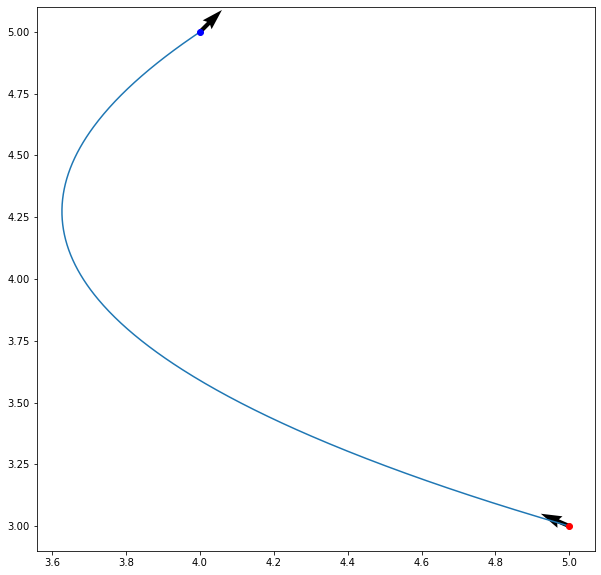

In [23]:
def gamma(t, p1, p2, u1, u2):
    t = np.array(t)
    a, d = p1[0], p1[1] #on connaît facilement les valeurs de a et d 
    M = np.array([[1, 1, 0, 0],    #on écrit la matrice de notre système 
                [0, 0, 1, 1],
                [u1[1], 0, -u1[0], 0],  #produits vectoriels
                [u2[1], 2*u2[1], -u2[0], -2*u2[0]]])
    if np.linalg.det(M) != 0: #si la matrice est inversible, on résout le système puis on regarde si les vecteurs sont dans le bon sens 
        b, c, e, f = np.linalg.solve(M, np.array([p2[0]-a, p2[1]-d, 0, 0]))
        A = np.array([b, e])
        NA = np.linalg.norm(A)
        B = np.array([b+2*c, e+2*f])
        NB = np.linalg.norm(B)
        NU1 = np.linalg.norm(u1)
        NU2 = np.linalg.norm(u2)
        ps1 = np.dot(A,u1)
        ps2 = np.dot(B,u2)
        if abs(ps1-NA*NU1)>1e-5 or abs (ps2-NB*NU2)>1e-5 :  # on ne teste pas l'égalité mais on veut une certaine précision car les calculs sur machine ne sont pas exacts 
            return np.array([p1[0]+(p2[0]-p1[0])*t, p1[1]+(p2[1]-p1[1])*t])
        else : 
            return np.array([a+b*t+c*t**2, d+e*t+f*t**2])
            
    else :
        return np.array([p1[0]+(p2[0]-p1[0])*t, p1[1]+(p2[1]-p1[1])*t])
        


p1=(5, 3)
p2=(4, 5)
u1=np.array([-2.3, 1])
u2=np.array([1, 1])


T=np.linspace(0, 1, 500)

plt.plot(gamma(T, p1, p2, u1, u2)[0], gamma(T, p1, p2, u1, u2)[1])
plt.plot(p1[0], p1[1], marker='o', color='red')
plt.plot(p2[0], p2[1], marker='o', color='blue')

plt.quiver(p1[0], p1[1], u1[0], u1[1])  
plt.quiver(p2[0], p2[1], u2[0], u2[1])  
plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [24]:
def level_curve_ameliore_oversampling(f, x0, y0, c, delta = 0.1, N2 = 1000, eps = eps, oversampling = 1):
    grad_f = grad(f)
    X, Y = [x0], [y0]
    x, y = x0, y0
    def F(x, y, x1, y1):
        return np.array([f(x,y) - c, np.sqrt((x-x1)**2 + (y-y1)**2) - delta])
    for i in range(N2):
        gf = grad_f(x, y)
        u = np.array([gf[1], -gf[0]])
        u = u/np.linalg.norm(u)
        x,y = x + delta*u[0], y + delta*u[1]
        x,y = Newton(lambda a, b : F(a,b,X[-1], Y[-1]), x, y)
        dist = np.sqrt((x-x0)**2 + (y-y0)**2)
        if dist < delta/1.3:
            k = i
            print(f"i = {i} !")
            break
        X.append(x)
        Y.append(y)
    for j in range(k+1):
        if oversampling > 1:
            n = oversampling - 1
            xx = np.linspace(1/(n+1),n/(n+1),n) #n points sont ajoutés, régulièrement espacés
            p1 = np.array([X[j-1],Y[j-1]]) #on choisit pour l'oversampling de prendre comme tangentes aux points k et k+1 les vecteurs (uk-1,uk) et (uk+1,uk) 
            p2 = np.array([X[j], Y[j]])
            u1 = np.array([X[j-1] - X[j-2], Y[j-1] - Y[j-2]])
            u2 = np.array([X[j] - X[j-1], Y[j] - Y[j-1]])
            X = np.concatenate((X, gamma(xx, p1, p2, u1, u2)[0]))
            Y = np.concatenate((Y, gamma(xx, p1, p2, u1, u2)[1]))
    return np.array([X, Y])

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

i = 33 !


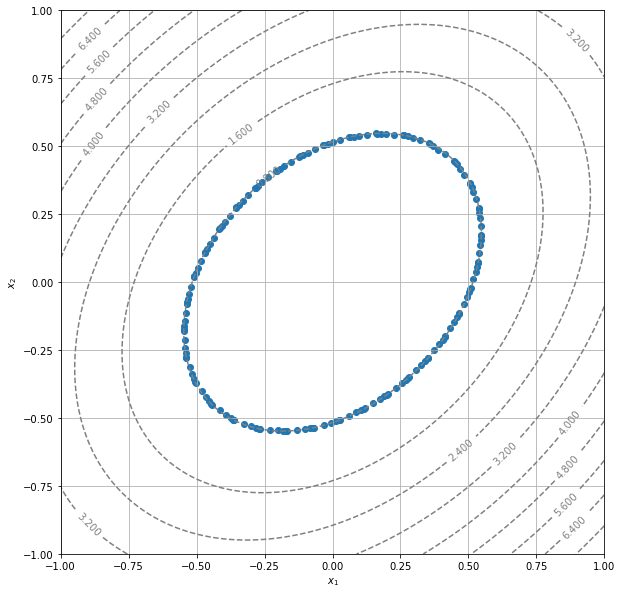

In [25]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2

def F1(x1, x2):    #La fonction de R2 dans R2 qui sert à amorcer la level_curve
    return np.array([f1(x1,x2) - 0.8, x1 - x2]) 

display_contour(   #on trace tout d'abord les lignes de niveau
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)

nx, ny = Newton(F1, 0.5, 0.5)   #les points pour amorcer la fonction level_curve

XY = level_curve_ameliore_oversampling(f1, nx, ny, 0.8, delta = 0.1, N2 = 10000, eps = 1e-2, oversampling = 5)
plt.scatter(XY[0], XY[1])

L'oversampling est déjà efficace avec une valeur de 5, on a bien amélioré la fonction level curve ! 